### Inference Analysis



# Proposal of baseline scores: 

Option 1: 
I propose giving an average on the three images (n_predictions =3) as the baseline dice score as option one
so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers
##found in last cell in effect of support set sizes


Option 2: 
Do the same but adding ensembling. 
##found at the end of this file


In [1]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import itertools
import math
import einops as E
import pathlib
import os
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple
from torch.utils.data import Dataset
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
    # Define input and mask folders for the JNU_FMI dataset
    test_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\test'
    test_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\test'
    
    support_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\train'
    support_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\train'
    
    # Define output folder for segmented images
    #output_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\segmented_images'
    

In [3]:


current_directory = os.getcwd()
print("Current directory:", current_directory)

# Get the current directory
current_directory = os.getcwd()

# List the contents of the current directory
contents = os.listdir(current_directory)

# Print the contents
print("Contents of the current directory:")
for item in contents:
    print(item)


Current directory: C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\universeg
Contents of the current directory:
.ipynb_checkpoints
Baseline using Universeg.ipynb
baseline_accuracy.csv
baseline_dicescore.csv
baseline_jaccard.csv
baseline_precision.csv
baseline_sensitivity.csv
inference_analysis - Copy.ipynb
inference_analysis.ipynb
label_path
model.py
nn
training.py
universeg_scratch.py
validation.py
__init__.py
__pycache__


In [4]:
# !git clone https://github.com/JJGO/UniverSeg
# !python -m pip install -r ./UniverSeg/requirements.txt
# # Add package directory to path
#!pip install torch


import torch
from model import universeg

# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'



# Instantiate the model and move it to the device
model = universeg(pretrained=True)
model.to(device)



UniverSeg(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (enc_blocks): ModuleList(
    (0): CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
      (support): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (1-3): 3 x CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_si

In [5]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

In [6]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()


In [7]:
#Accuracy score implemented
def accuracy_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    correct = (y_pred == y_true).sum().item()
    total = y_true.numel()
    accuracy = correct / total
    
    return accuracy

In [8]:
def sensitivity_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum().item()
    sensitivity = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    return sensitivity

In [9]:
def precision_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_positives = ((y_pred == 1) & (y_true == 0)).sum().item()
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0

    return precision

In [10]:
def jaccard_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    intersection = ((y_pred == 1) & (y_true == 1)).sum().item()
    union = ((y_pred == 1) | (y_true == 1)).sum().item()
    jaccard = intersection / union if union != 0 else 0

    return jaccard

In [11]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Move the model to the GPU
    device = torch.device('cuda')
    model.to(device)
    print("Model moved to CUDA (GPU)")
else:
    print("CUDA is not available. Model remains on CPU.")


Model moved to CUDA (GPU)


In [12]:
#torch.cuda.get_arch_list()

### funtions for processing images 


### creating bounding boxes


#dice score 30

In [13]:
import PIL
import numpy as np
import pathlib
from typing import Tuple

import PIL
import numpy as np
import pathlib
from typing import Tuple

def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with hot encoded selection of areas."""
    # Load input image
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    img = np.array(img)
    img = img.astype(np.float32)
    return img
#     


def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)

    # One-hot encoded representation of segmentation mask
    seg = np.expand_dims(seg > 0, axis=0)
    return seg.astype(np.float32)

def apply_rois(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
    """Apply regions of interest (ROIs) from segmentation mask to input image."""
    # Apply the mask to the input image
    img_with_rois = np.where(seg_mask[0], image, 0)
    img_with_rois = img_with_rois.astype(np.float32)



    return img_with_rois

import cv2




# Example usage:
# img_path = pathlib.Path("C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\partitioned_dataset\\images\\test\\20190830T115515_269.png")
# seg_mask_path = pathlib.Path("C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\partitioned_dataset\\masks\\test\\20190830T115515_269_mask.png")

# # Process input image with hot encoded selection of areas
# processed_img = process_image(img_path, seg_mask_path, size=(128, 128), augment=False)
# import matplotlib.pyplot as plt
# 
# # Print the processed image
# plt.imshow(processed_img, cmap='gray')
# plt.axis('off')
# plt.show()



### convex hull

In [14]:
# import cv2
# import PIL
# import numpy as np
# import pathlib
# from typing import Tuple
# 
# def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
#     """Process input image with hot encoded selection of areas."""
#     # Load input image
#     img = PIL.Image.open(image_path)
#     img = img.resize(size, resample=PIL.Image.BILINEAR)
#     img = img.convert("L")
#     img = np.array(img)
#     img = img.astype(np.float32)
#     return img
# 
def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)

    # One-hot encoded representation of segmentation mask
    seg_mask = np.stack([seg == 0, seg == 128, seg == 255])
    #seg_mask = seg_mask.convert("L")
    seg = seg_mask.astype(np.float32)
    #print(seg)
#     
# 
#     return seg
# 
# import cv2
# import numpy as np
# 
# # def apply_convex_hull(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
# #     """Apply convex hull to regions of interest (ROIs) from segmentation mask on input image."""
# #     # Find contours in the segmentation mask
# #     contours, _ = cv2.findContours(seg_mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# #     
# #     # Create a mask for the convex hull
# #     convex_hull_mask = np.zeros_like(seg_mask[0], dtype=np.uint8)
# #     
# #     # Draw the convex hull on the mask
# #     for contour in contours:
# #         hull = cv2.convexHull(contour)
# #         cv2.drawContours(convex_hull_mask, [hull], -1, 255, -1)  # -1 for filled
# #         
# #     # Apply the convex hull mask to the input image
# #     img_with_convex_hull = cv2.bitwise_and(image, image, mask=convex_hull_mask)
# #     
# #     return img_with_convex_hull
# 
# 
# 
# # Load the input image and segmentation mask
# # img_path = pathlib.Path(".png")
# # seg_mask_path = pathlib.Path("path_to_seg_mask.png")
# 
# # img_path = pathlib.Path(r"C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\example_data\partitioned_dataset\images\test\20190909T155747_689.png")
# # seg_mask_path = pathlib.Path(r"C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\test\20190909T155747_689_mask.png")
# # size = (128, 128)
# # 
# # img = process_image(img_path, seg_mask_path, size)
# # seg_mask = process_seg(seg_mask_path, size)
# 
# # Apply convex hull to the processed image and segmentation mask
# #img_with_convex_hull = apply_convex_hull(img, seg_mask)
# 
# #import matplotlib.pyplot as plt
# 
# # import matplotlib.pyplot as plt
# # 
# # # Display the original image
# # plt.figure(figsize=(8, 8))
# # plt.subplot(1, 2, 1)
# # plt.imshow(img, cmap='gray')
# # plt.title('Original Image')
# # plt.axis('off')
# # 
# # # Display each channel of the segmentation mask separately
# # plt.figure(figsize=(8, 8))
# # for i in range(seg_mask.shape[0]):
# #     plt.subplot(1, seg_mask.shape[0], i + 1)
# #     plt.imshow(seg_mask[i], cmap='gray')
# #     plt.title(f'Segmentation Mask Channel {i + 1}')
# #     plt.axis('off')
# # 
# # # # Display the image with convex hull
# # # plt.figure(figsize=(8, 8))
# # # plt.subplot(1, 2, 2)
# # # plt.imshow(img_with_convex_hull, cmap='gray')
# # # plt.title('Image with Convex Hull')
# # # plt.axis('off')
# # 
# # plt.show()
# 


### load dataset correct

In [15]:
# def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128)):
#     """Load dataset from input and mask folders."""
#     data = []
#     input_path = pathlib.Path(input_folder)
#     mask_path = pathlib.Path(mask_folder)
# 
#     # Sort images based on numerical values in filenames
#     input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
# 
#     for file in input_files:
#         img = process_image(file,mask_path, size=size)
#         img_name = file.stem
#         # print(img_name)
# 
#        # Load mask
#         seg = None
#         seg_file = mask_path / f"{img_name}_mask.png"
#         if seg_file.exists():
#             seg = process_seg(seg_file, size=size)
#            # print(f"Loaded mask for {img_name}")
#         else:
#             print(f"Mask file '{seg_file}' not found. Skipping.")
#             
#         img_with_rois = apply_rois(img, seg)
# 
#         data.append((img_with_rois / 255.0, seg))
# 
#     return data


# input_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\MedSAM\\up_dataset\\us_data\\partitioned_dataset\\images\\test"
# mask_folder = "C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\MedSAM\\up_dataset\\us_data\\partitioned_dataset\\masks\\test"
# 
# data = load_dataset(input_folder, mask_folder)
# for img, mask in data:
#     print("Image shape:", img.shape)
#     print("Mask shape:", mask.shape)


### with rois

In [16]:
def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128)):
    """Load dataset from input and mask folders."""
    data = []
    input_path = pathlib.Path(input_folder)
    mask_path = pathlib.Path(mask_folder)

    # Sort images based on numerical values in filenames
    input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        

    for file in input_files:
        img = process_image(file,mask_path, size=size)
        img_name = file.stem

        # Load segmentation mask
        seg_file = mask_path / f"{img_name}_mask.png"
        if seg_file.exists():
            seg = process_seg(seg_file, size=size)
        else:
            print(f"Mask file '{seg_file}' not found. Skipping.")
            continue

        # Apply regions of interest (ROIs) to input image
        #img_with_co = apply_rois(img, seg)

        data.append((img / 255.0, seg))

    return data


In [17]:
from dataclasses import dataclass
from typing import Optional, Tuple, Literal
import os
import torch
import pathlib
import numpy as np
import PIL.Image
from torch.utils.data import Dataset

@dataclass
class JNU_FMI:
    input_folder: str
    label: str
    size: Tuple[int, int] = (128, 128)
    label_name: Optional[Literal["head", "symp", "background"]] = None
    
    def __post_init__(self):
        self._data = load_dataset(self.input_folder, self.label, size=self.size)
        T = torch.from_numpy
        
        # Assign indices based on sorted filenames
        self._data = [(T(x)[None], T(y)) for x, y in self._data]
         
        
        if self.label is not None:
            self.masks = sorted(os.listdir(self.label), key=lambda x: int(x.split('_')[-2]))
            if self.label in self.masks:
                self._ilabel = {"head": 1, "symp": 2, "background": 0}[self.label]
        
        self.idxs = list(range(len(self._data)))
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
        img, seg = self._data[self.idxs[idx]]
        # if self.label is not None:
        #     seg = seg[self.label_name][None]
        return img, seg


### Visualizations

In [18]:
# def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None, figsize=(15, 15)):
#     M = len(tensors)
#     N = len(next(iter(tensors.values())))
# 
#     cols = col_wrap
#     rows = math.ceil(N/cols) * M
# 
#     d = 2.5
#     fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
#     if rows == 1:
#       axes = axes.reshape(1, cols)
# 
#     for g, (grp, tensors) in enumerate(tensors.items()):
#         for k, tensor in enumerate(tensors):
#             col = k % cols
#             row = g + M*(k//cols)
#             x = tensor.detach().cpu().numpy().squeeze()
#             ax = axes[row,col]
#             if len(x.shape) == 2:
#                 ax.imshow(x,vmin=0, vmax=1, cmap='gray')
#             else:
#                 ax.imshow(E.rearrange(x,'C H W -> H W C'))
#             if col == 0:
#                 ax.set_ylabel(grp, fontsize=16)
#             if col_names is not None and row == 0:
#                 ax.set_title(col_names[col])
# 
#     for i in range(rows):
#         for j in range(cols):
#             ax = axes[i,j]
#             ax.grid(False)
#             ax.set_xticks([])
#             ax.set_yticks([])
# 
#     if title:
#         plt.suptitle(title, fontsize=20)
# 
#     plt.tight_layout()

### visualiations

In [19]:
# d_support = WBCDataset('JTSC', split='support', label=None)
# d_test = WBCDataset('JTSC', split='test', label=None)

d_support = JNU_FMI(support_input_folder, label=support_mask_folder)
d_test = JNU_FMI(test_input_folder, label=test_mask_folder)

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [20]:
# n_viz = 16
# visualize_tensors({
#     'Support Image': support_images[:n_viz],
#     'Support Label': support_labels[:n_viz],
# }, 8, title='Support Set Examples - Multi Label')

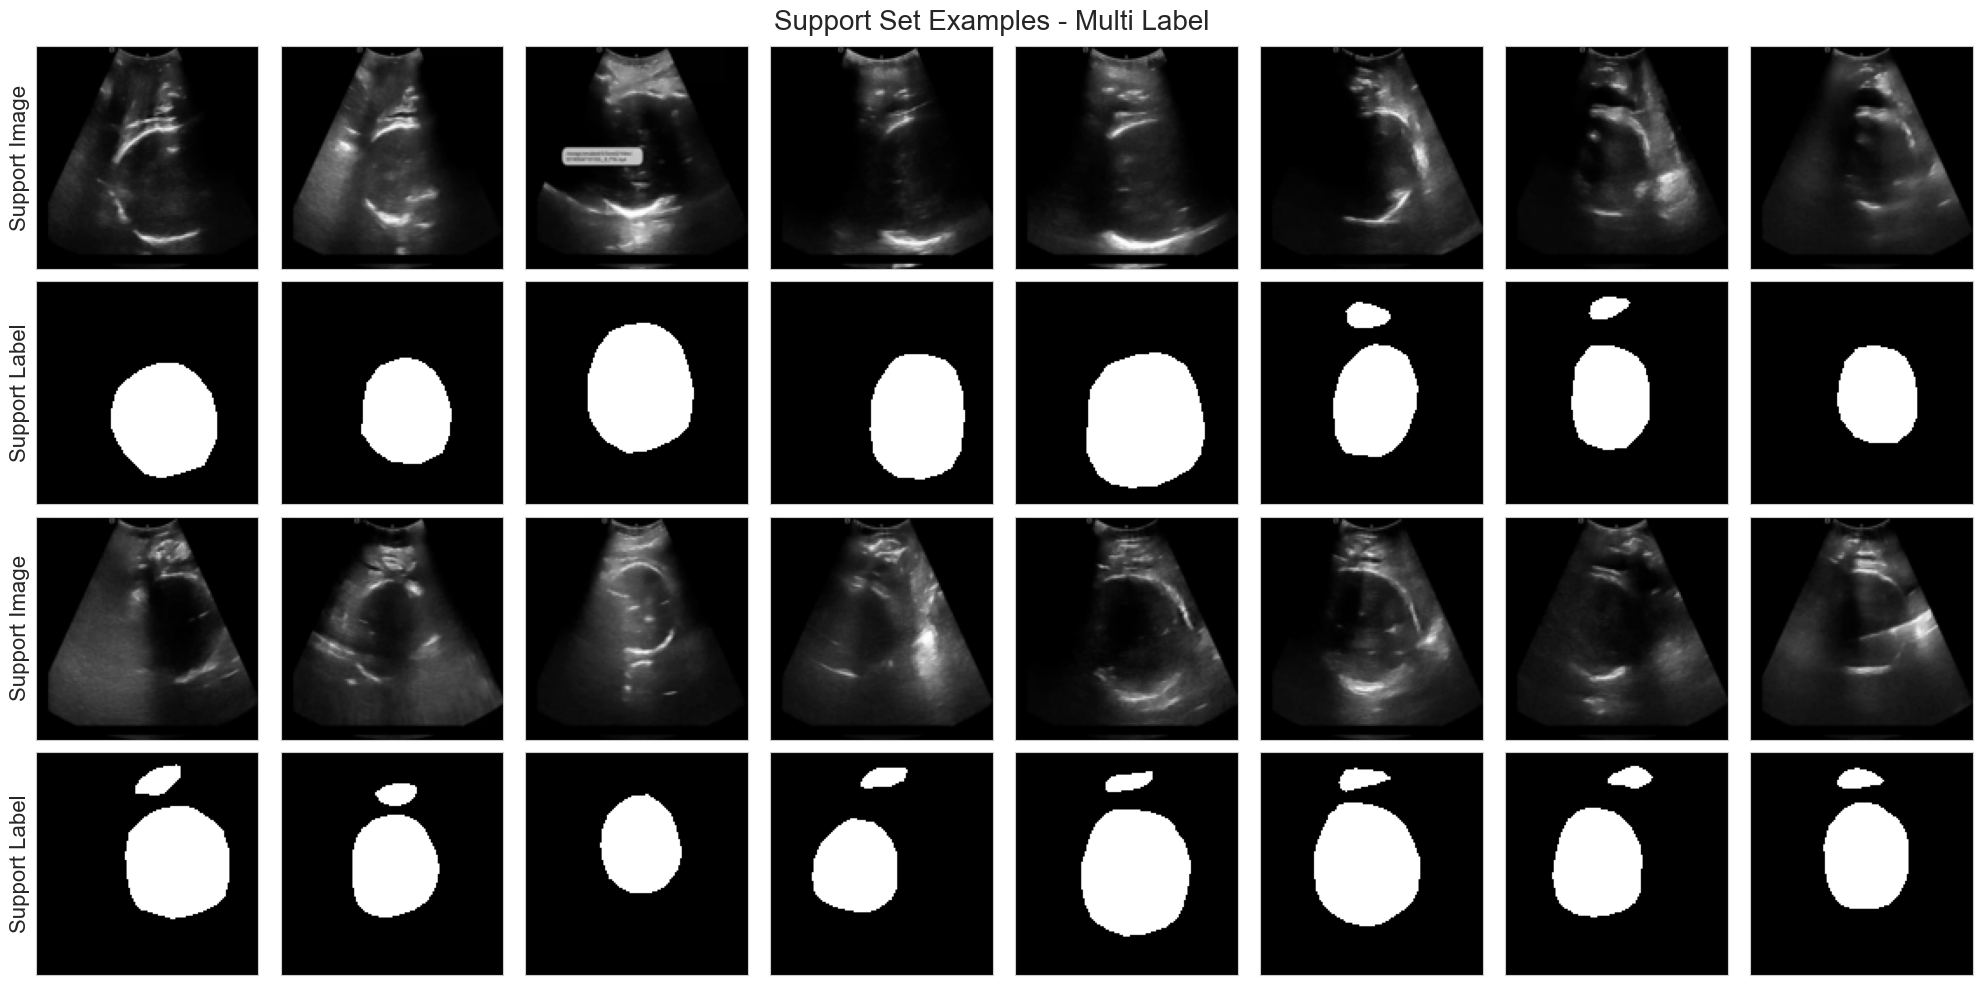

In [21]:
n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, 8, title='Support Set Examples - Multi Label')


In [22]:
# # prepare a function that will perform inference on all available labels
# import torch.nn.functional as F
# 
# # Dice metric for measuring volume agreement
# def soft_dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
#     print(2*(y_pred*y_true).sum())
#     score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
#     return score.item()
# 
# @torch.no_grad()
# def inference_multi(model, image, label_onehot, support_images, support_labels_onehot):
#     # get data
#     n_labels = label_onehot.shape[0]
#     image, label_onehot = image.to(device), label_onehot.to(device)
# 
#     # go through label
#     all_logits = []
#     soft_pred_onehot = []
#     for k in range(n_labels):
#         # extract the right label
#         label = label_onehot[k:k+1]
#         support_labels = support_labels_onehot[:,k:k+1]
# 
#         # run inference on this label
#         logits = model(
#             image[None],
#             support_images[None],
#             support_labels[None]
#         )[0][0] # outputs are logits
#         soft_pred = torch.sigmoid(logits)
#         soft_pred_onehot.append(soft_pred)
# 
#     # get multi-label score
#     soft_pred_onehot = torch.stack(soft_pred_onehot)
#     hard_pred = F.softmax(10*soft_pred_onehot, dim=0)
#     scores = []
#     for k in range(n_labels):
#         score = soft_dice_score(hard_pred[k], label_onehot[k])
#         scores.append(score)
# 
#     # return the predictions and labels
#     return {'Image': image,
#             'Soft Prediction': soft_pred_onehot,
#             'Prediction': hard_pred,
#             'Ground Truth': label_onehot,
#             'score': np.mean(scores)}

In [23]:
# import torch.nn.functional as F
# 
# 
# 
# @torch.no_grad()
# def inferencesupport(model, image, label, support_images, support_labels):
#     image, label = image.to(device), label.to(device)
# 
#     # inference
#     logits = model(
#         image[None],
#         support_images[None],
#         support_labels[None]
#     )[0] # outputs are logits
# 
#     soft_pred = torch.sigmoid(logits)
#     hard_pred = soft_pred.round().clip(0,1)
# 
#     #  score
#     dicescore = dice_score(hard_pred, label)
#     accuracy = accuracy_score(hard_pred,label)
#     sensitivity =sensitivity_score(hard_pred,label)
#     precision=precision_score(hard_pred,label)
#     jaccard=jaccard_score(hard_pred,label)
# 
#     # return a dictionary of all relevant variables
#     # return {'Image': image,
#     #         'Soft Prediction': soft_pred,
#     #         'Prediction': hard_pred,
#     #         'Ground Truth': label,
#     #         'score': dicescore,
#     #         'accuracy' : accuracy,
#     #         'sensitivity':sensitivity,
#     #         'precision':precision,
#     #         'jaccard' : jaccard}
#     return {'Image': image,
#             'Soft Prediction': soft_pred,
#             'Prediction': hard_pred,
#             'Ground Truth': label,
#             'score': dicescore,
#             'accuracy' : accuracy,
#             'sensitivity':sensitivity,
#             'precision':precision,
#             'jaccard' : jaccard}

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'inferencesupport' is not defined

In [ ]:
# import pandas as pd
# import random
# 
# support_set_sizes = [1, 2, 4, 8, 16, 32, 64]
# 
# # Create empty DataFrames for each metric
# df_dicescore = pd.DataFrame(columns=support_set_sizes)
# df_accuracy = pd.DataFrame(columns=support_set_sizes)
# df_sensitivity = pd.DataFrame(columns=support_set_sizes)
# df_precision = pd.DataFrame(columns=support_set_sizes)
# df_jaccard = pd.DataFrame(columns=support_set_sizes)
# 
# for image, label in d_test:
#     dice_scores = {}
#     acc = {}
#     sens = {}
#     prec = {}
#     jac = {}
#     for N in support_set_sizes:
#         # Randomly select N indices for both images and labels
#         random_indices = random.sample(range(len(d_support)), N)
#         random_support = [(d_support[i][0], d_support[i][1]) for i in random_indices]
#         
#         # Unzip the random_support into images and labels
#         support_images, support_labels = zip(*random_support)
#         
#         # Convert support_images into a PyTorch tensor and move it to the device
#         support_images = torch.stack(support_images).to(device)
#         support_labels = torch.stack(support_labels).to(device)
#         
#         # Call the function for inference
#         vals = inferencesupport(model, image, label, support_images, support_labels)
#         
#         # Store the metrics
#         dice_scores[N] = vals['score'] if 'score' in vals else None
#         acc[N] = vals['accuracy'] if 'accuracy' in vals else None
#         sens[N] = vals['sensitivity'] if 'sensitivity' in vals else None
#         prec[N] = vals['precision'] if 'precision' in vals else None
#         jac[N] = vals['jaccard'] if 'jaccard' in vals else None
# 
#     df_dicescore = pd.concat([df_dicescore, pd.DataFrame(dice_scores, index=[0])], ignore_index=True)
#     df_accuracy = pd.concat([df_accuracy, pd.DataFrame(acc, index=[0])], ignore_index=True)
#     df_sensitivity = pd.concat([df_sensitivity, pd.DataFrame(sens, index=[0])], ignore_index=True)
#     df_precision = pd.concat([df_precision, pd.DataFrame(prec, index=[0])], ignore_index=True)
#     df_jaccard = pd.concat([df_jaccard, pd.DataFrame(jac, index=[0])], ignore_index=True)

In [ ]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm

# Assuming device, dice_score, accuracy_score, sensitivity_score, precision_score, jaccard_score, 
# inferencesupport, and visualize_tensors are already defined

def calculate_dice_score(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    # Handling cases with no masks in the ground truth
    if target.sum() == 0:
        return 1.0 if pred.sum() == 0 else 0.0
    
    return dice

@torch.no_grad()
def inferencesupport(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0]  # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0, 1)

    # score
    dicescore = calculate_dice_score(hard_pred, label)
    accuracy = accuracy_score(hard_pred, label)
    sensitivity = sensitivity_score(hard_pred, label)
    precision = precision_score(hard_pred, label)
    jaccard = jaccard_score(hard_pred, label)

    return {
        'Image': image,
        'Soft Prediction': soft_pred,
        'Prediction': hard_pred,
        'Ground Truth': label,
        'score': dicescore,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'precision': precision,
        'jaccard': jaccard
    }

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inferencesupport(model, image, label, support_images, support_labels)
    
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

In [ ]:
import PIL
import numpy as np
import pathlib
from typing import Tuple
from collections import defaultdict
from tqdm import tqdm
import torch

def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with hot encoded selection of areas."""
    # Load input image
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    img = np.array(img)
    img = img.astype(np.float32)
    return img

def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)

    # One-hot encoded representation of segmentation mask
    seg = np.expand_dims(seg > 0, axis=0)
    return seg.astype(np.float32)

def apply_rois(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
    """Apply regions of interest (ROIs) from segmentation mask to input image."""
    # Apply the mask to the input image
    img_with_rois = np.where(seg_mask[0], image, 0)
    img_with_rois = img_with_rois.astype(np.float32)
    return img_with_rois

def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128)):
    """Load dataset from input and mask folders."""
    data = []
    input_path = pathlib.Path(input_folder)
    mask_path = pathlib.Path(mask_folder)

    # Sort images based on numerical values in filenames
    input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        
    for file in input_files:
        img = process_image(file, mask_path, size=size)
        img_name = file.stem

        # Load segmentation mask
        seg_file = mask_path / f"{img_name}_mask.png"
        if seg_file.exists():
            seg = process_seg(seg_file, size=size)
        else:
            print(f"Mask file '{seg_file}' not found. Skipping.")
            continue

        # Apply regions of interest (ROIs) to input image
        img_with_rois = apply_rois(img, seg)

        data.append((img / 255.0, seg))

    return data

def calculate_dice_score(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    # Handling cases with no masks in the ground truth
    if target.sum() == 0:
        return 1.0 if pred.sum() == 0 else 0.0
    
    return dice

# Assuming inferencesupport and visualize_tensors are already defined

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inferencesupport(model, image, label, support_images, support_labels)
    
    # Calculate Dice score
    pred = vals['prediction']
    target = label
    
    # Apply soft prediction thresholding if needed
    soft_pred = vals.get('soft_prediction')
    if soft_pred is not None:
        pred = (soft_pred > 0.5).float()  # Binarize soft predictions if available
    
    dice_score = calculate_dice_score(pred, target)
    vals['score'] = dice_score
    
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

In [ ]:
# n_predictions = 10
# 
# results = defaultdict(list)
# idxs = np.random.permutation(len(d_test))[:n_predictions]
# 
# for i in tqdm(idxs):
#     image, label = d_test[i]
#     vals = inferencesupport(model, image, label, support_images, support_labels)
#     for k, v in vals.items():
#         results[k].append(v)
# 
# scores = results.pop('score')
# visualize_tensors(results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

In [ ]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

Let's perform inference on a test entry and visualize the prediction

### Inference Analysis


##### Change support labels

In [ ]:
# n_support = 64

In [ ]:
##changing input not possible at the moment since we only have one dataset

### Effect of the Support Set Size

In [ ]:

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)



In [ ]:
n_predictions = 3 #1446
support_set_sizes = [1, 2, 4, 8, 16, 32, 64,128,256,512]

## why certain pictures random 

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inferencesupport(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))
# Print the list of Dice scores for different support set sizes
# for N, dice_scores in zip(support_set_sizes, results_dict['Dice Score']):
#     print(f"Support Set Size: {N}, Dice Scores: {dice_scores}")


# Print the list of Dice scores for different support set sizes
# for N, dice_scores in results_dict.items():
#     average_dice_score = np.mean(dice_scores)
#     print(f"Support Set Size: {N}, Average Dice Score: {average_dice_score}")

# Print the list of Dice scores for different support set sizes


#### Average dice score per support set size

In [ ]:
# n_predictions = 3  # 1446
# support_set_sizes = [1, 2, 4, 8, 16, 32, 64]
# 
# # Collect dice scores for different support set sizes
# results_dict = defaultdict(list)
# 
# # why certain pictures random 
# idxs = np.random.permutation(len(d_test))[:n_predictions]
# 
# for i in idxs:
#     for N in support_set_sizes:
#         image, label = d_test[i]
#         vals = inferencesupport(model, image, label, support_images[:N], support_labels[:N])
#         score = vals['score']
#         results_dict[N].append(score)
# 
# # Print the list of average Dice scores for each support set
# for N, dice_scores in results_dict.items():
#     average_dice_score = np.mean(dice_scores)
#     print(f"Support Set Size: {N}, Average Dice Score: {average_dice_score}")


In [ ]:
# # Import necessary libraries
# from collections import defaultdict
# import numpy as np
# 
# # Define variables
# n_predictions = 3  # Number of test images to randomly select
# support_set_sizes = [1, 2, 4, 8, 16, 32, 64]  # Different support set sizes
# 
# # Dictionary to collect dice scores for different support set sizes
# results_dict = defaultdict(list)
# 
# # Randomly select test images
# idxs = np.random.permutation(len(d_test))[:n_predictions]
# 
# # Iterate over the selected test images
# for i in idxs:
#     # Iterate over different support set sizes
#     for N in support_set_sizes:
#         # Get the test image and its label
#         image, label = d_test[i]
#         # Perform inference and get the dice score
#         #vals = inference_multi(model, image, label, support_images[:N], support_labels[:N])
#         vals = inferencesupport(model, image, label, support_images[:N], support_labels[:N])
#         score = vals['score']
#         # Collect the dice score for this support set size
#         results_dict[N].append(score)
# 
# # Calculate the average Dice score across all support set sizes for each test image
# average_dice_scores = []
# for i in range(n_predictions):
#     dice_scores_for_image = [results_dict[N][i] for N in support_set_sizes]
#     average_dice_score_for_image = np.mean(dice_scores_for_image)
#     average_dice_scores.append(average_dice_score_for_image)
# 
# # Print the average Dice score for each test image
# for i, average_dice_score in enumerate(average_dice_scores, start=1):
#     print(f"Average Dice Score for random Test Image {i}: {average_dice_score}")
# 
#     
#     #randomly chosen images, so not like in the index of the original datasets

In [ ]:
##I propose giving an average on the three images as the baseline dice score as option one
#so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers


#### Multi-label Predictions

In [ ]:
# d_support = VentricleDataset(support_input_folder, label=None)
# d_test = VentricleDataset(test_input_folder, label=None)
# 
# n_support = 64
# 
# support_images, support_labels = zip(*itertools.islice(d_support, n_support))
# support_images = torch.stack(support_images).to(device)
# support_labels = torch.stack(support_labels).to(device)

### Ensembling Predictions

In [ ]:
# # helpful function to sample support data
# def sample_support(seed):
#     rng = np.random.default_rng(seed)
#     idxs = rng.integers(0,len(d_support), size=support_size)
#     support_images, support_labels = zip(*[d_support[i] for i in idxs])
#     support_images = torch.stack(support_images).to(device)
#     support_labels = torch.stack(support_labels).to(device)
#     return support_images, support_labels

In [ ]:
# # get support data
# # d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
# # d_test = WBCDataset('JTSC', split='test', label='cytoplasm')
# 
# 
# # setup the number of predictions and ensembling
# support_size = 8
# n_predictions = 3
# n_ensemble = 5
# 
# # get various support sets
# idxs = np.random.permutation(len(d_test))[:n_predictions]
# seeds = range(n_ensemble)
# supports = {
#     seed: sample_support(seed)
#     for seed in range(n_ensemble)
# }
# 
# # go through the number of experiments
# for i in idxs:
# 
#     # go through the number of predictions we will ensemble
#     results = defaultdict(list)
#     for j in range(n_ensemble):
#         # get support set and query
#         support_images, support_labels = sample_support(j)
#         image, label = d_test[i]
# 
#         # perform inference
#         vals = inferencesupport(model, image, label, support_images, support_labels)
#         for k, v in vals.items():
#             results[k].append(v)
# 
#     results['Image'].append(image)
#     ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
#     results['Soft Prediction'].append(ensemble)
#     results['Prediction'].append(ensemble.round())
#     results['Ground Truth'].append(label)
#     results['score'].append(dice_score(ensemble.round(), label.to(device)))
# 
#     scores = results.pop('score')
#     col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
#     col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
# 
#     visualize_tensors(results,
#                       col_names=col_names,
#                       title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
#                       col_wrap=n_ensemble+1)

In [ ]:
##option 2 would be doing same as option one but including ensembling 

  0%|          | 0/10 [00:38<?, ?it/s]


RuntimeError: "bitwise_and_cuda" not implemented for 'Float'

100%|██████████| 10/10 [01:43<00:00, 10.34s/it]


AttributeError: 'float' object has no attribute 'detach'

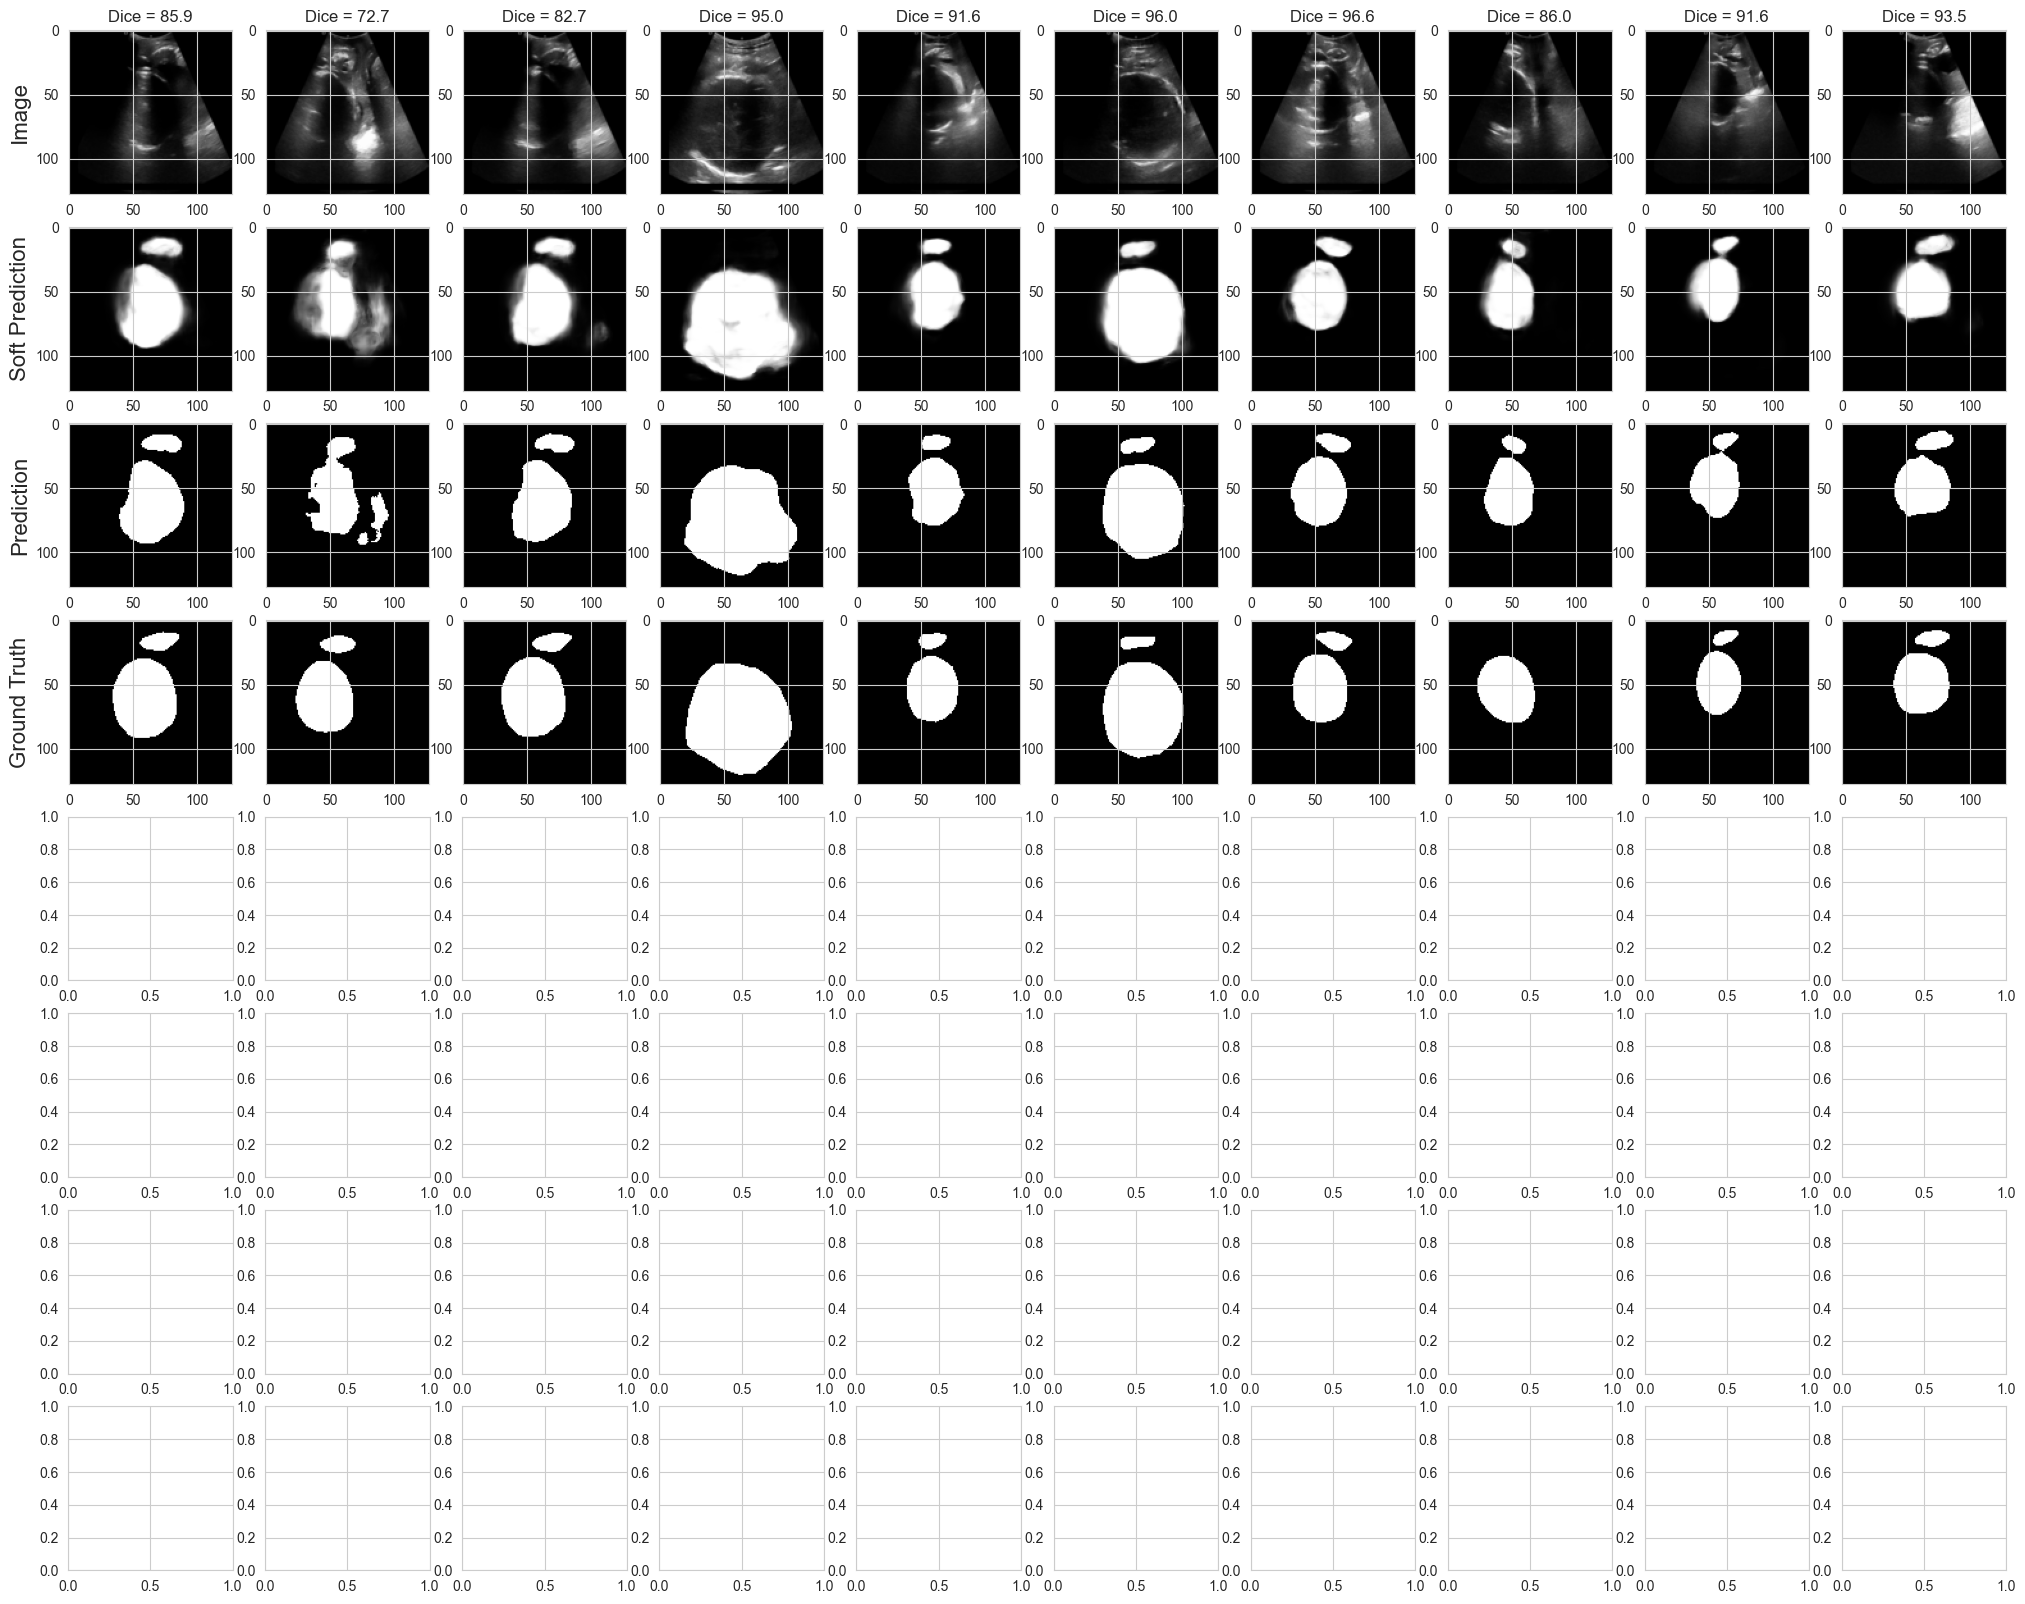

100%|██████████| 10/10 [01:46<00:00, 10.62s/it]


Dice Scores: [tensor(0.8816, device='cuda:0'), 0.0, 0.0, tensor(0.9059, device='cuda:0'), tensor(0.9516, device='cuda:0'), tensor(0.9740, device='cuda:0'), tensor(0.9362, device='cuda:0'), tensor(0.9543, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.9478, device='cuda:0')]


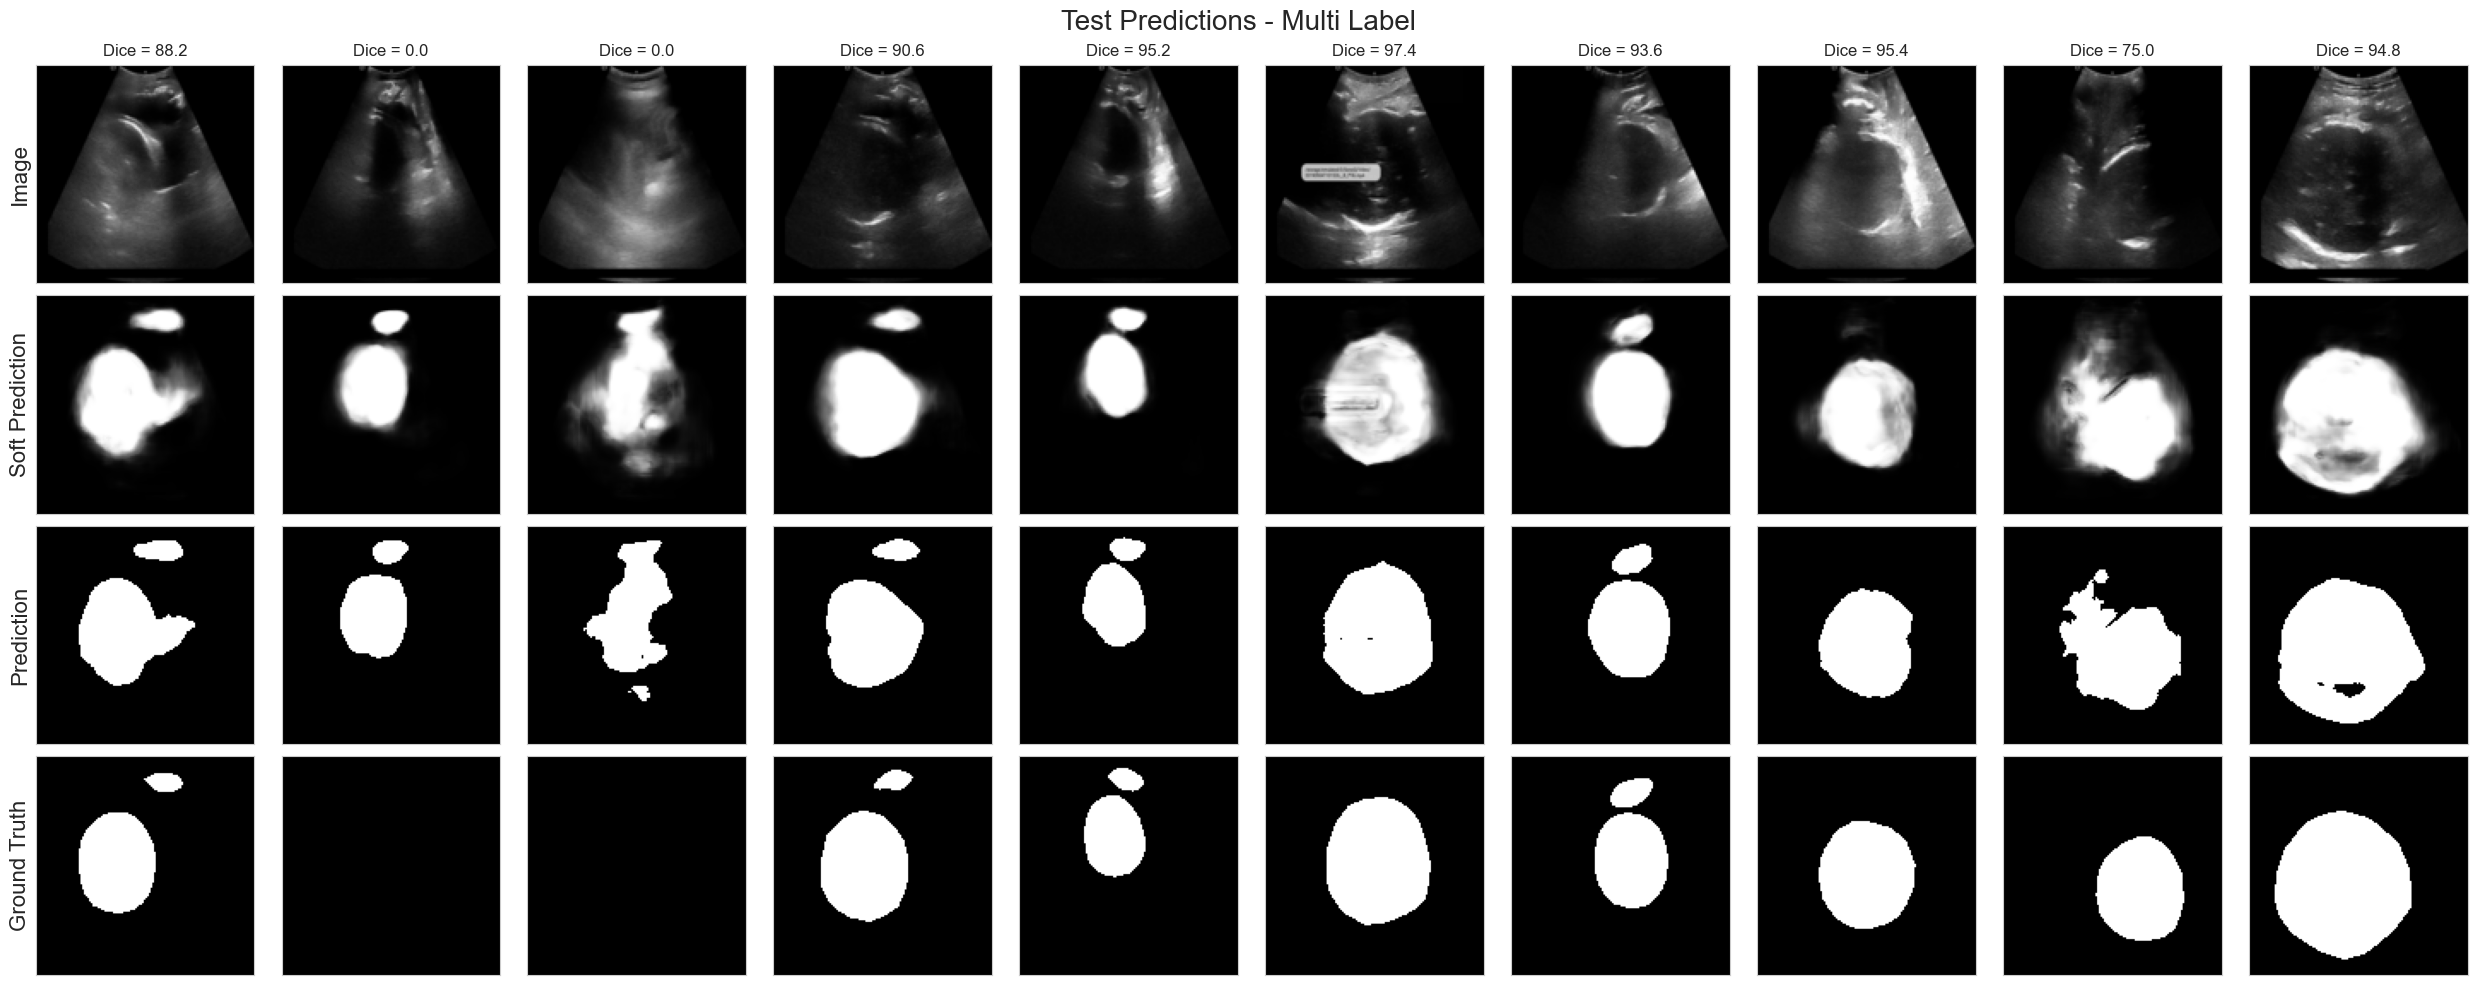

100%|██████████| 10/10 [01:28<00:00,  8.82s/it]


Dice Scores: [tensor(0.9305, device='cuda:0'), tensor(0.9097, device='cuda:0'), tensor(0.9227, device='cuda:0'), 0.0, tensor(0.9531, device='cuda:0'), tensor(0.9608, device='cuda:0'), 0.0, tensor(0.7300, device='cuda:0'), tensor(0.7997, device='cuda:0'), tensor(0.1749, device='cuda:0')]


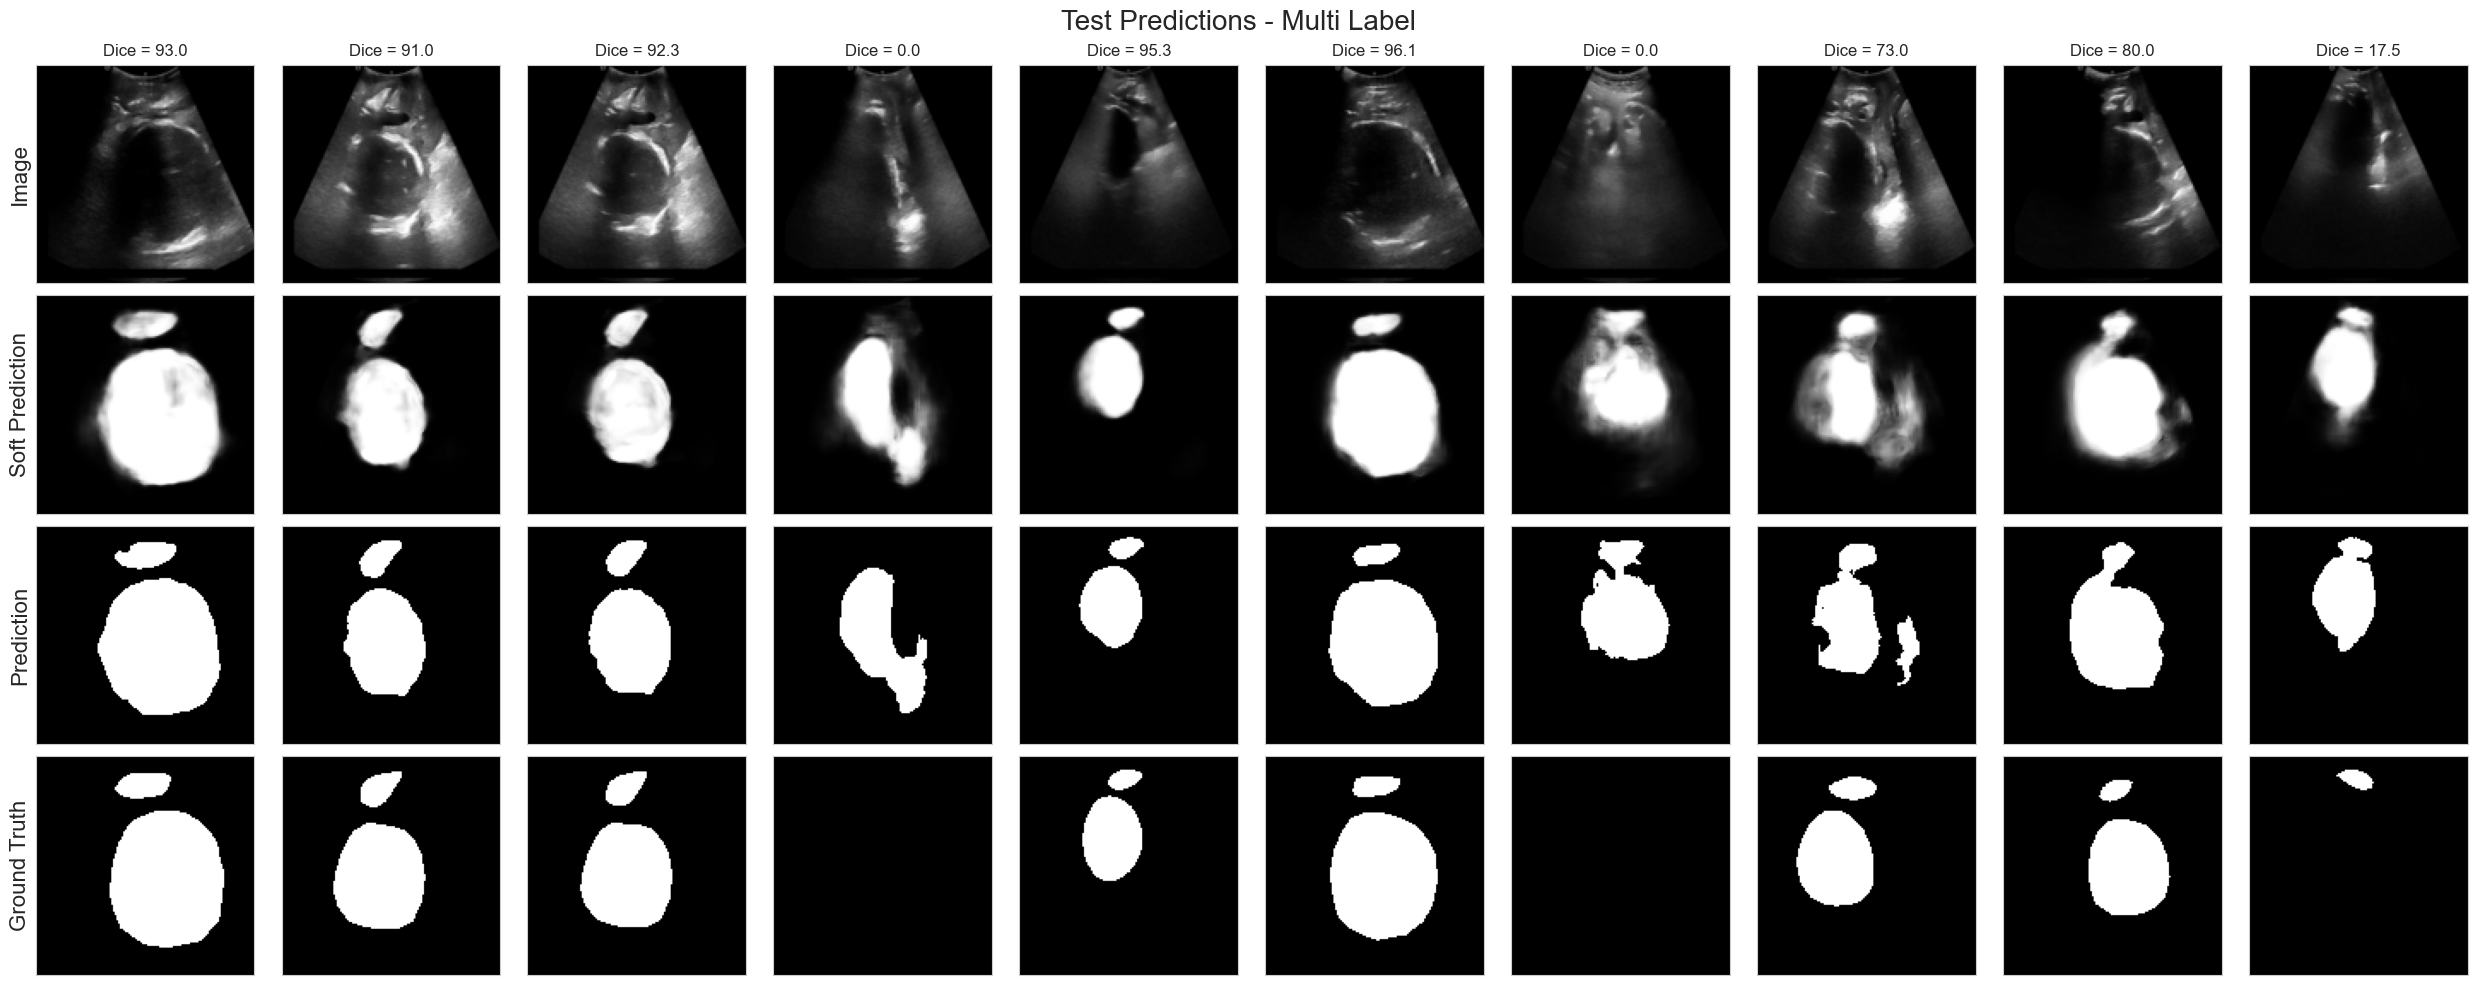

ModuleNotFoundError: No module named 'dataset'

ModuleNotFoundError: No module named 'dataset'

100%|██████████| 10/10 [02:33<00:00, 15.33s/it]


Dice Scores: [tensor(0.9268, device='cuda:0'), tensor(0.9538, device='cuda:0'), tensor(0.7566, device='cuda:0'), tensor(0.9621, device='cuda:0'), tensor(0.7370, device='cuda:0'), tensor(0.9317, device='cuda:0'), tensor(0.5461, device='cuda:0'), tensor(0.9023, device='cuda:0'), 0.0, tensor(0.9200, device='cuda:0')]
Dice Scores: [tensor(0.9268, device='cuda:0'), tensor(0.9538, device='cuda:0'), tensor(0.7566, device='cuda:0'), tensor(0.9621, device='cuda:0'), tensor(0.7370, device='cuda:0'), tensor(0.9317, device='cuda:0'), tensor(0.5461, device='cuda:0'), tensor(0.9023, device='cuda:0'), 0.0, tensor(0.9200, device='cuda:0')]


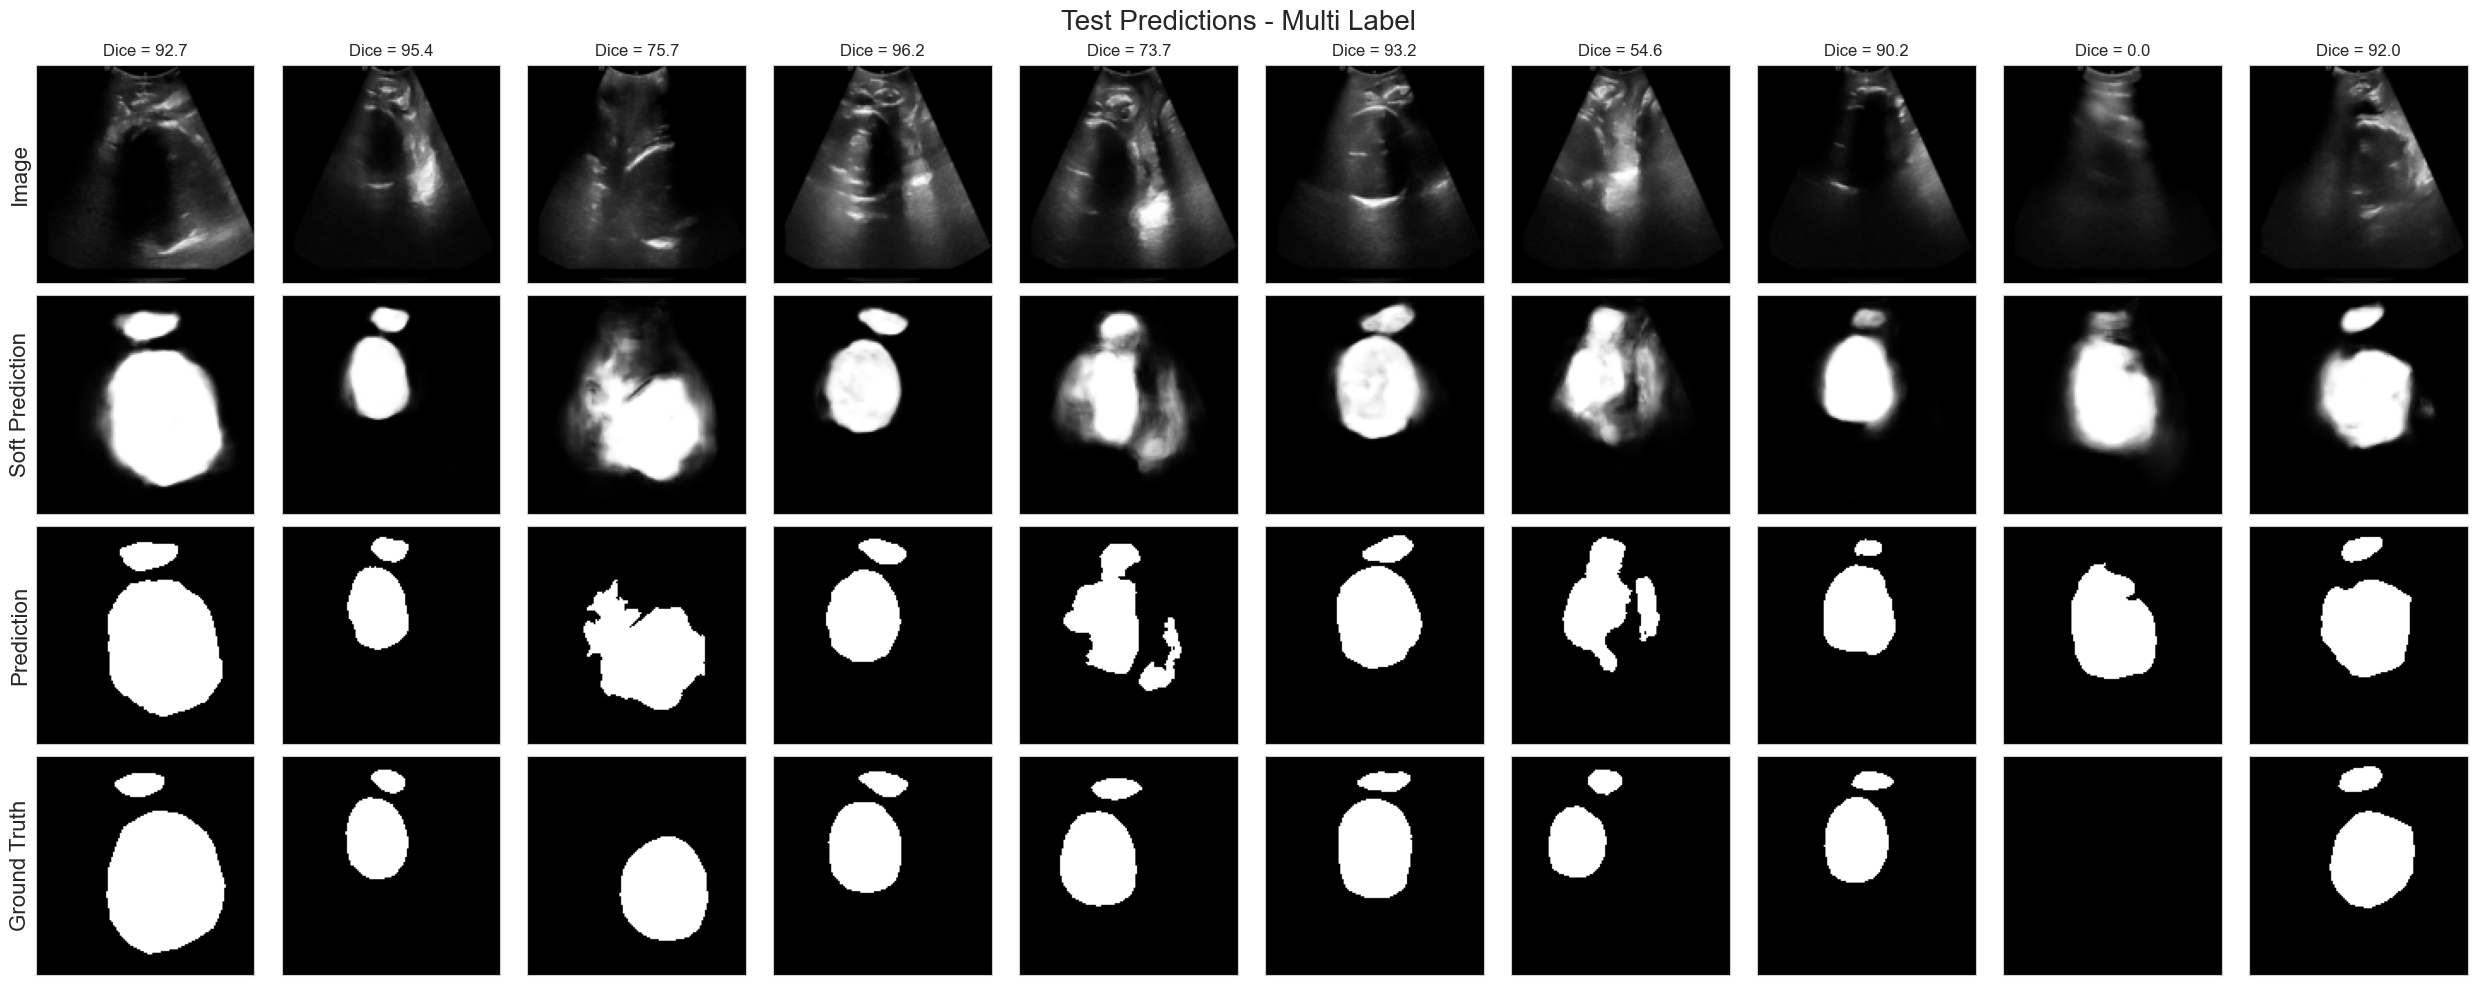

In [38]:
import PIL
import numpy as np
import pathlib
import torch
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm
from typing import Tuple, Optional, Literal
import scipy.ndimage as ndi
import os
from torch.utils.data import Dataset
import torchvision.transforms as T
from dataclasses import dataclass

# Assuming device, accuracy_score, sensitivity_score, precision_score, jaccard_score, visualize_tensors are already defined

def process_image(image_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with optional augmentation."""
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    if augment:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(30),
        ])
        img = transform(img)
    img = np.array(img).astype(np.float32)
    return img

def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask with one-hot encoding."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = np.array(seg)
    
    # Assuming mask values are 0, 128, 255 for different classes and background
    seg_one_hot = np.stack([seg == 0, seg == 128, seg == 255], axis=-1)
    seg_one_hot = seg_one_hot.astype(np.float32)
    
    return seg_one_hot

def apply_rois(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
    """Apply regions of interest (ROIs) from segmentation mask to input image."""
    img_with_rois = np.where(seg_mask.any(axis=-1, keepdims=True), image, 0).astype(np.float32)
    return img_with_rois

def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128), augment: bool = False):
    """Load dataset from input and mask folders."""
    data = []
    input_path = pathlib.Path(input_folder)
    mask_path = pathlib.Path(mask_folder)

    input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        
    for file in input_files:
        img = process_image(file, size=size, augment=augment)
        img_name = file.stem

        seg_file = mask_path / f"{img_name}_mask.png"
        if seg_file.exists():
            seg = process_seg(seg_file, size=size)
        else:
            print(f"Mask file '{seg_file}' not found. Skipping.")
            continue

        img_with_rois = apply_rois(img, seg)
        data.append((img / 255.0, seg))

    return data

@dataclass
class JNU_FMI:
    input_folder: str
    label: str
    size: Tuple[int, int] = (128, 128)
    augment: bool = False
    label_name: Optional[Literal["head", "symp", "background"]] = None
    
    def post_init(self):
        self._data = load_dataset(self.input_folder, self.label, size=self.size, augment=self.augment)
        T = torch.from_numpy
        
        # Assign indices based on sorted filenames
        self._data = [(T(x)[None], T(y)) for x, y in self._data]
        
        if self.label is not None:
            self.masks = sorted(os.listdir(self.label), key=lambda x: int(x.split('_')[-2]))
            self._ilabel = {"head": 1, "symp": 2, "background": 0}.get(self.label_name, 0)
        
        self.idxs = list(range(len(self._data)))
        
    def len(self):
        return len(self._data)
    
    def getitem(self, idx):
        img, seg = self._data[self.idxs[idx]]
        # Select the specific mask label if available
        if self.label_name is not None:
            seg = seg[:, :, self._ilabel]
        return img, seg

def calculate_dice_score(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    if target.sum() == 0:
        return 1.0 if pred.sum() == 0 else 0.0
    
    return dice

def post_process_prediction(pred, min_size=100):
    labeled_pred, num_features = ndi.label(pred.cpu().numpy())
    sizes = ndi.sum(pred.cpu().numpy(), labeled_pred, range(num_features + 1))
    
    mask_size = sizes < min_size
    remove_pixel = mask_size[labeled_pred]
    labeled_pred[remove_pixel] = 0
    
    cleaned_pred = torch.tensor(labeled_pred).float().to(pred.device)
    cleaned_pred[cleaned_pred > 0] = 1
    
    return cleaned_pred

@torch.no_grad()
def inferencesupport(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0]  # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0, 1)
    
    # Post-process the prediction
    hard_pred = post_process_prediction(hard_pred)
    
    dicescore = calculate_dice_score(hard_pred, label)
    accuracy = accuracy_score(hard_pred, label)
    sensitivity = sensitivity_score(hard_pred, label)
    precision = precision_score(hard_pred, label)
    jaccard = jaccard_score(hard_pred, label)

    return {
        'Image': image,
        'Soft Prediction': soft_pred,
        'Prediction': hard_pred,
        'Ground Truth': label,
        'score': dicescore,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'precision': precision,
        'jaccard': jaccard
    }

# Example function definitions for accuracy_score, sensitivity_score, precision_score, and jaccard_score
def accuracy_score(pred, target):
    correct = (pred == target).float()
    accuracy = correct.sum() / target.numel()
    return accuracy.item()

def sensitivity_score(pred, target):
    true_positive = ((pred == 1) & (target == 1)).float().sum()
    false_negative = ((pred == 0) & (target == 1)).float().sum()
    sensitivity = true_positive / (true_positive + false_negative + 1e-6)
    return sensitivity.item()

def precision_score(pred, target):
    true_positive = ((pred == 1) & (target == 1)).float().sum()
    false_positive = ((pred == 1) & (target == 0)).float().sum()
    precision = true_positive / (true_positive + false_positive + 1e-6)
    return precision.item()

def jaccard_score(pred, target):
    pred = pred.int()  # Convert to integer type
    target = target.int()  # Convert to integer type
    intersection = (pred & target).float().sum()
    union = (pred | target).float().sum()
    jaccard = intersection / (union + 1e-6)
    return jaccard.item()

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inferencesupport(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# Extract scores for logging
scores = results.pop('score')
print(f"Dice Scores: {scores}")

# Prepare images and other tensors for visualization
image_results = {k: v for k, v in results.items() if k in ['Image', 'Soft Prediction', 'Prediction', 'Ground Truth']}
visualize_tensors(image_results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

print(f"Dice Scores: {scores}")

100%|██████████| 10/10 [03:17<00:00, 19.79s/it]


Dice Scores: [tensor(0.6736, device='cuda:0'), tensor(0.9190, device='cuda:0'), tensor(0.9653, device='cuda:0'), tensor(0.7114, device='cuda:0'), tensor(0.6590, device='cuda:0'), tensor(0.6637, device='cuda:0'), tensor(0.7979, device='cuda:0'), tensor(0.9718, device='cuda:0'), tensor(0.9108, device='cuda:0'), 0.0]
Dice Scores: [tensor(0.6736, device='cuda:0'), tensor(0.9190, device='cuda:0'), tensor(0.9653, device='cuda:0'), tensor(0.7114, device='cuda:0'), tensor(0.6590, device='cuda:0'), tensor(0.6637, device='cuda:0'), tensor(0.7979, device='cuda:0'), tensor(0.9718, device='cuda:0'), tensor(0.9108, device='cuda:0'), 0.0]


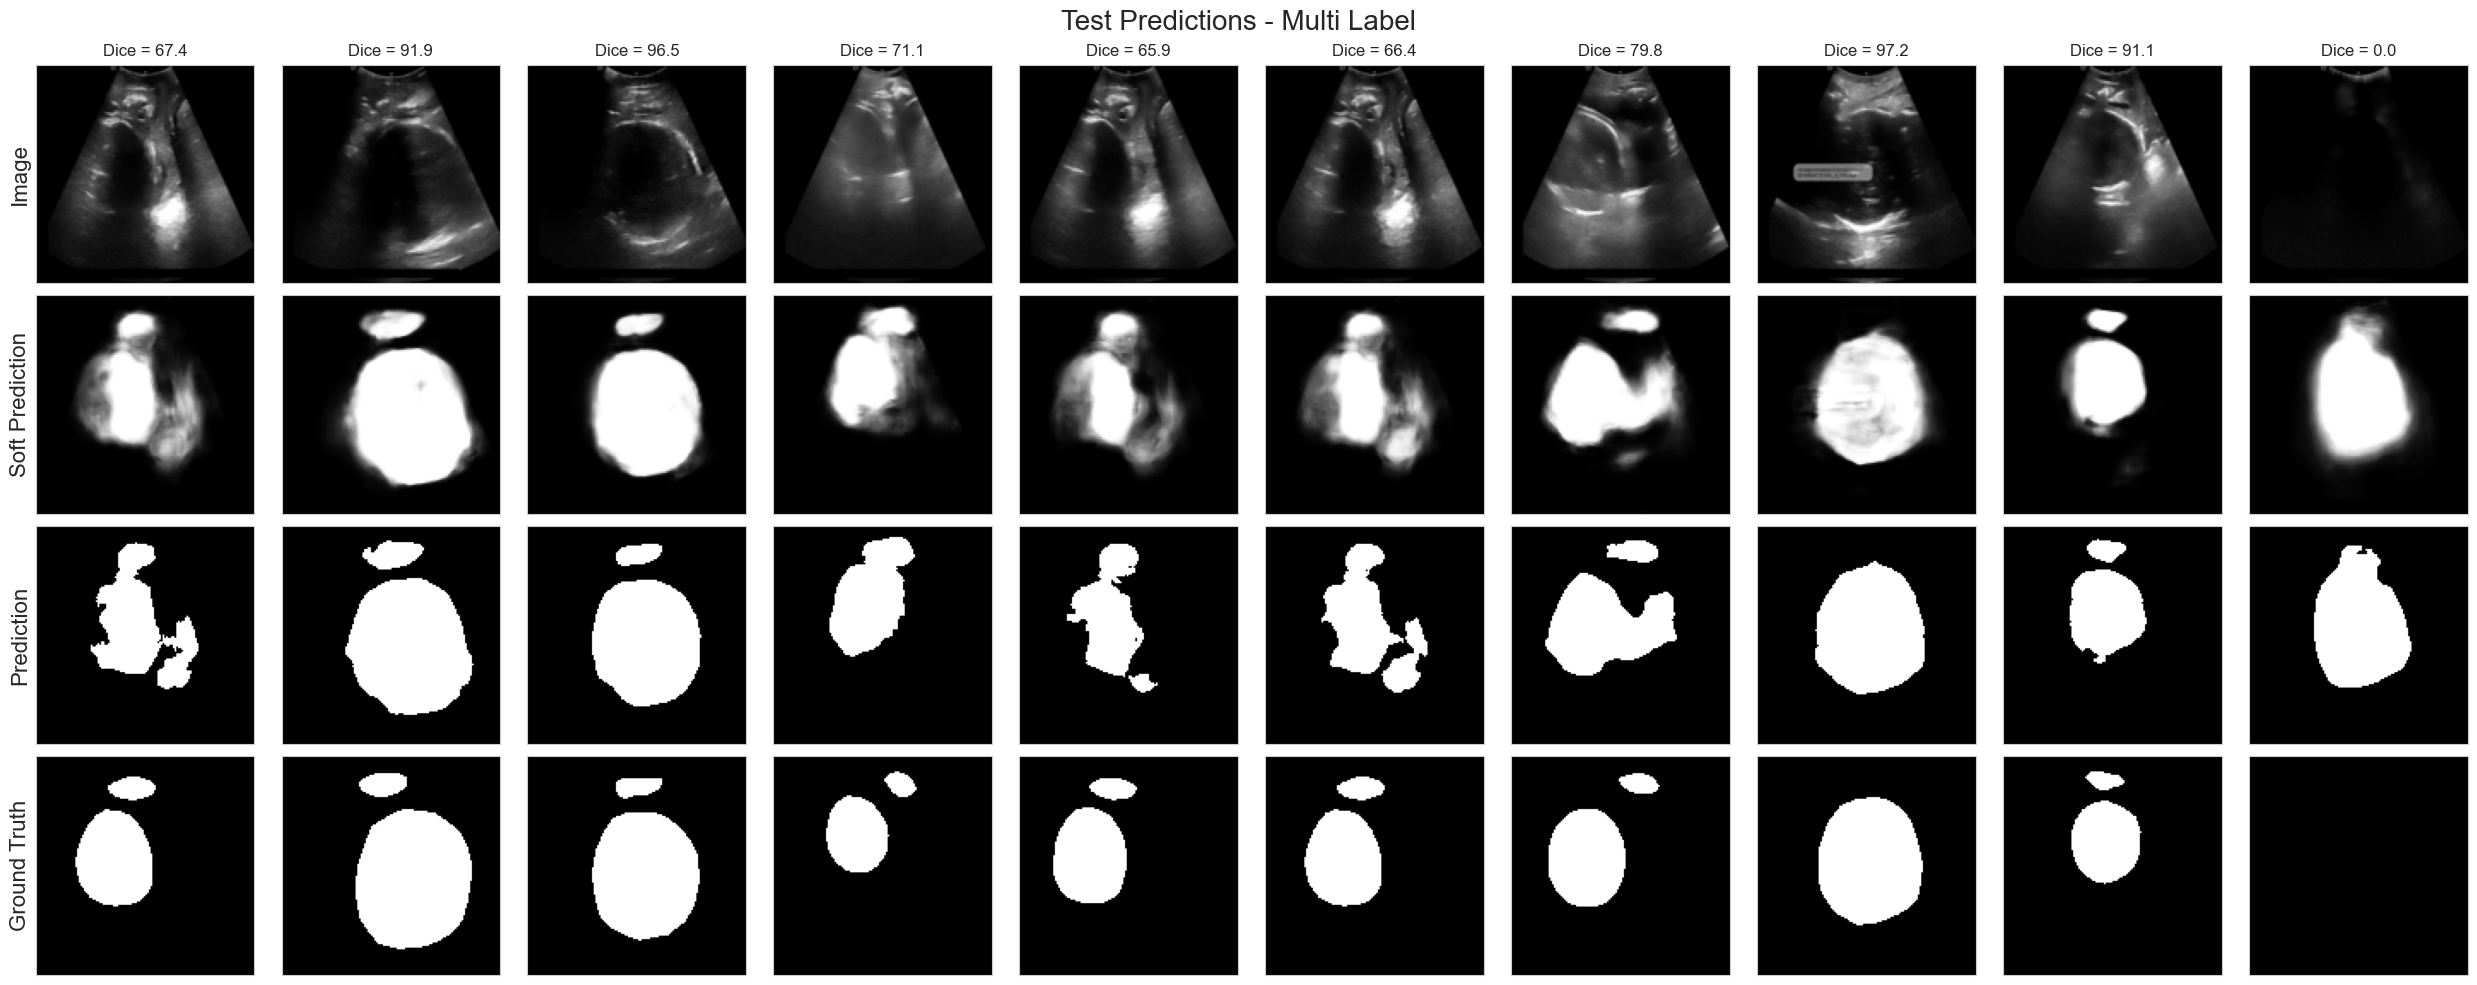

In [37]:
import PIL
import numpy as np
import pathlib
import torch
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm
from typing import Tuple, Optional, Literal
import scipy.ndimage as ndi
import os
from torch.utils.data import Dataset
import torchvision.transforms as T
from dataclasses import dataclass

# Assuming device, accuracy_score, sensitivity_score, precision_score, jaccard_score, visualize_tensors are already defined

def process_image(image_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with optional augmentation."""
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    if augment:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(30),
        ])
        img = transform(img)
    img = np.array(img).astype(np.float32)
    return img

def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)
    
    # Binary mask where non-black areas are 1 and black areas are 0
    seg_mask = (seg != 0).astype(np.float32)
    
    return seg_mask

def apply_rois(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
    """Apply regions of interest (ROIs) from segmentation mask to input image."""
    img_with_rois = np.where(seg_mask, image, 0).astype(np.float32)
    return img_with_rois

def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128), augment: bool = False):
    """Load dataset from input and mask folders."""
    data = []
    input_path = pathlib.Path(input_folder)
    mask_path = pathlib.Path(mask_folder)

    input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        
    for file in input_files:
        img = process_image(file, size=size, augment=augment)
        img_name = file.stem

        seg_file = mask_path / f"{img_name}_mask.png"
        if seg_file.exists():
            seg = process_seg(seg_file, size=size)
        else:
            print(f"Mask file '{seg_file}' not found. Skipping.")
            continue

        img_with_rois = apply_rois(img, seg)
        data.append((img / 255.0, seg))

    return data

@dataclass
class JNU_FMI:
    input_folder: str
    label: str
    size: Tuple[int, int] = (128, 128)
    augment: bool = False
    label_name: Optional[Literal["head", "symp", "background"]] = None
    
    def post_init(self):
        self._data = load_dataset(self.input_folder, self.label, size=self.size, augment=self.augment)
        T = torch.from_numpy
        
        # Assign indices based on sorted filenames
        self._data = [(T(x)[None], T(y)) for x, y in self._data]
        
        if self.label is not None:
            self.masks = sorted(os.listdir(self.label), key=lambda x: int(x.split('_')[-2]))
            self._ilabel = {"head": 1, "symp": 2, "background": 0}.get(self.label_name, 0)
        
        self.idxs = list(range(len(self._data)))
        
    def len(self):
        return len(self._data)
    
    def getitem(self, idx):
        img, seg = self._data[self.idxs[idx]]
        # Select the specific mask label if available
        if self.label_name is not None:
            seg = (seg == self._ilabel).float()
        return img, seg

def calculate_dice_score(pred, target, smooth=1.0):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    if target.sum() == 0:
        return 1.0 if pred.sum() == 0 else 0.0
    
    return dice

def post_process_prediction(pred, min_size=100):
    labeled_pred, num_features = ndi.label(pred.cpu().numpy())
    sizes = ndi.sum(pred.cpu().numpy(), labeled_pred, range(num_features + 1))
    
    mask_size = sizes < min_size
    remove_pixel = mask_size[labeled_pred]
    labeled_pred[remove_pixel] = 0
    
    cleaned_pred = torch.tensor(labeled_pred).float().to(pred.device)
    cleaned_pred[cleaned_pred > 0] = 1
    
    return cleaned_pred

@torch.no_grad()
def inferencesupport(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0]  # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0, 1)
    
    # Post-process the prediction
    hard_pred = post_process_prediction(hard_pred)
    
    dicescore = calculate_dice_score(hard_pred, label)
    accuracy = accuracy_score(hard_pred, label)
    sensitivity = sensitivity_score(hard_pred, label)
    precision = precision_score(hard_pred, label)
    jaccard = jaccard_score(hard_pred, label)

    return {
        'Image': image,
        'Soft Prediction': soft_pred,
        'Prediction': hard_pred,
        'Ground Truth': label,
        'score': dicescore,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'precision': precision,
        'jaccard': jaccard
    }

# Example function definitions for accuracy_score, sensitivity_score, precision_score, and jaccard_score
def accuracy_score(pred, target):
    correct = (pred == target).float()
    accuracy = correct.sum() / target.numel()
    return accuracy.item()

def sensitivity_score(pred, target):
    true_positive = ((pred == 1) & (target == 1)).float().sum()
    false_negative = ((pred == 0) & (target == 1)).float().sum()
    sensitivity = true_positive / (true_positive + false_negative + 1e-6)
    return sensitivity.item()

def precision_score(pred, target):
    true_positive = ((pred == 1) & (target == 1)).float().sum()
    false_positive = ((pred == 1) & (target == 0)).float().sum()
    precision = true_positive / (true_positive + false_positive + 1e-6)
    return precision.item()

def jaccard_score(pred, target):
    pred = pred.int()  # Convert to integer type
    target = target.int()  # Convert to integer type
    intersection = (pred & target).float().sum()
    union = (pred | target).float().sum()
    jaccard = intersection / (union + 1e-6)
    return jaccard.item()

n_predictions = 10

results = defaultdict(list)
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inferencesupport(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# Extract scores for logging
scores = results.pop('score')
print(f"Dice Scores: {scores}")

# Prepare images and other tensors for visualization
image_results = {k: v for k, v in results.items() if k in ['Image', 'Soft Prediction', 'Prediction', 'Ground Truth']}
visualize_tensors(image_results, col_names=[f'Dice = {100*s:.1f}' for s in scores], title='Test Predictions - Multi Label', col_wrap=n_predictions)

print(f"Dice Scores: {scores}")